In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import matplotlib.ticker as mtick
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
K_set = 1
T_set = 10
I_set = 4

In [3]:
budget_levels = range(0,30+1)
level_amount_incrememented = 10000

reliability_levels = [.5,.75,.95]
dynamic = True

warehouse_cap_level = 1 #time intervals average amount of supply that can be stored

trade_off_dict = {}

In [4]:
def triangular_dist_demand(a,b,c,prob):
    if prob <= (c-a)/(b-a):
        return(a+((((prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((1-prob)*(b-a)*(b-c))**(1/2)))

In [5]:
def triangular_dist_supply(a,b,c,prob):
    if 1-prob <= (c-a)/(b-a):
        return(a+((((1-prob)*(b-a)*(c-a)))**(1/2)))
    else:
        return(b-(((prob)*(b-a)*(b-c))**(1/2)))

In [6]:
def lead_time_dist(a,b,c):
    lead_time_dist_array = np.zeros(T_set+1)
    cum_prob = 0
    t = 0
    
    while t < b+1:
        if t+1 <= a:
            t = t+1 
        elif (a < t+1 & t+1 <= c):
            cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
        elif c < t+1 & t+1 <= b+1:
            cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
            prob = cum_prob_temp - cum_prob
            lead_time_dist_array[t] = prob
            cum_prob = cum_prob_temp
            t = t+1
    
    return(lead_time_dist_array)

In [7]:
#define demand attributes

dem_dictionary_k = {1: [40000, 80000, 50000]
}

#define supply attributes
#capacity
cap_dictionary_supplier_SKU = {1: [9000,11000,10000], #min, max, likely, a,b,c
                     2: [10000,20000,15000], 
                     3: [13000,20000,17000],
                     4: [40000,100000,60000]}


#lead-time
lead_time_dictionary_supplier_SKU = {1: [3,5,4], #min, max, likely, a,b,c
                     2: [1,3,2], 
                     3: [3,5,4],
                     4: [0,2,0]}

#dynamic adj
dynamic_adj_dem = [0.5, 0.55, 0.6, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.85]
dynamic_adj_supply = np.zeros(T_set)
for t in range(1, T_set+1):
    if dynamic_adj_dem[t-1] < 1:
        dynamic_adj_supply[t-1] = 1+(1-dynamic_adj_dem[t-1])
    else:
        dynamic_adj_supply[t-1] = 2-dynamic_adj_dem[t-1]

In [8]:
def initialize_model(reliability_level, 
                     budget_level):
    
    k = 1

    #define parameters

    ###health care commodity metric parameters####
    #rank
    r_k_dict = {
        1 : 1
    }

    #quality 
    q_k_i_dict = {
        tuple([1,1]) : 1.3,
        tuple([1,2]): 1.2,
        tuple([1,3]): 1.2,
        tuple([1,4]): 1.1
    }


    ####Supply Parameters#####

    #lead time (supplier 3 has the lowest lead time)
    f_k_i_tDiff_dict = {}
    for i in range(1,I_set+1):
        lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                             lead_time_dictionary_supplier_SKU.get(i)[1],
                                             lead_time_dictionary_supplier_SKU.get(i)[2])
        for t in range(0,T_set+1):
                    f_k_i_tDiff_dict[tuple([k,i,t])] = lead_time_dist_array[t]


    #incoming orders
    o_k_i_t_dict = {}

    for k in range(1,K_set+1):
        for i in range(1,I_set+1):
            for t in range(1,T_set+1):
                if t <= 2:
                    o_k_i_t_dict[tuple([k,i,t])] = 0 #20000/4 #5000
                else:
                    o_k_i_t_dict[tuple([k,i,t])] = 0



    #lead time (supplier 1 has the higest capacity)
    CAP_k_i_t_dict = {}

    for i in range(1,I_set+1):
        cap_temp = triangular_dist_supply(cap_dictionary_supplier_SKU.get(i)[0],
                                          cap_dictionary_supplier_SKU.get(i)[1],
                                          cap_dictionary_supplier_SKU.get(i)[2],
                                          reliability_level)
        if (dynamic == True):
            for t in range(1,T_set+1):
                cap_temp_2 = cap_temp*dynamic_adj_supply[t-1]
                CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp_2
        else:
            for t in range(1,T_set+1):
                CAP_k_i_t_dict[tuple([k,i,t])] = cap_temp

    ####Demand Parameters####
    n_k_init_dict = {
        1 : 0
    }


    #demand RV
    D_k_t_dict = {}
    demand_temp = triangular_dist_demand(dem_dictionary_k.get(k)[0],
                                         dem_dictionary_k.get(k)[1],
                                         dem_dictionary_k.get(k)[2],
                                         reliability_level)

    if (dynamic == True):
        for t in range(1,T_set+1):
            demand_temp_2 =demand_temp*dynamic_adj_dem[t-1]
            D_k_t_dict[tuple([k,t])] = demand_temp_2
    else:
        for t in range(1,T_set+1):
            D_k_t_dict[tuple([k,t])] = demand_temp


    #starting inventory
    z_k_i_init_dict = {
        tuple([1,1]) : 80000/4,
        tuple([1,2]) : 80000/4,
        tuple([1,3]) : 80000/4,
        tuple([1,4]) : 80000/4
    }

    #size
    s_k_dict = {
        1 : 1
    }

    #warehouse capacity
    h = 80000*warehouse_cap_level 

    #cost (supplier 2 has the lowest cost)
    c_k_i_dict = {
        tuple([1,1]) : 2,
        tuple([1,2]) : 1.5,
        tuple([1,3]) : 1,
        tuple([1,4]) : .8
    }

    b = 100000*budget_level
    
    model = ConcreteModel()

    #####define sets#######
    model.K = Set(initialize = range(1,K_set+1))
    model.I = Set(initialize = range(1,I_set+1))
    model.T = Set(initialize = range(1,T_set+1))
    model.T_0 = Set(initialize = range(0,T_set+1))

    ####initialize parameters####

    def rank_param_initialize(model, k):
        return(r_k_dict.get(k))

    model.r_k = Param(model.K, initialize = rank_param_initialize)

    def discount_param_initialize(model, k, t):
        discount_temp = 1/model.r_k[k]
        return(1/((1+discount_temp)**(t)))

    model.tau_k_t = Param(model.K, model.T_0, initialize = discount_param_initialize)

    #model.tau_k_t.pprint()

    def quality_param_initialize(model, k, i):
        return(q_k_i_dict.get(tuple([k,i])))

    model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

    #model.q_k_i.pprint()

    def delay_dist_param_initialize(model, k, i, t):
        return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

    model.f_k_i_tDiff = Param(model.K, model.I, model.T_0, 
                              initialize = delay_dist_param_initialize)

    #model.f_k_i_tDiff.pprint()

    def incoming_orders_initialize(model, k, i, t):
        return(o_k_i_t_dict.get(tuple([k,i,t])))

    model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

    #model.o_k_i_t.pprint()

    def supplier_cap_param_initialize(model, k, i, t):
        return(CAP_k_i_t_dict.get(tuple([k,i,t])))

    model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

    #model.cap_k_i_t.pprint()

    def unfulfilled_demand_param_initialize(model, k):
        return(n_k_init_dict.get(k))

    model.n_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

    #model.n_k_intialize.pprint()

    #assume preparing for one sd above the mean
    def demand_param_initialize(model, k, t):
        return(D_k_t_dict.get(tuple([k,t])))

    model.d_k_t = Param(model.K, model.T, initialize = demand_param_initialize)

    #model.d_k_t.pprint()

    def beg_inv_param_initialize(model, k, i):
        return(z_k_i_init_dict.get(tuple([k,i])))

    model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

    #model.z_k_i_init.pprint()

    def item_size_param_initialize(model, k):
        return(s_k_dict.get(k))

    model.s_k = Param(model.K, initialize = item_size_param_initialize)

    #model.s_k.pprint()

    def warehouse_cap_param_initialize(model):
        return(h)

    model.h = Param(initialize = h)

    #model.h.pprint()

    def cost_param_initialize(model, k, i):
        return(c_k_i_dict.get(tuple([k,i])))

    model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

    #model.c_k_i.pprint()

    def budget_param_initialize(model):
        return(b)

    model.b = Param(initialize = budget_param_initialize)

    #model.b.pprint()

    ####initialize variables####
    model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
    model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
    model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    model.n_k_t = Var(model.K, model.T, model.T_0, within = NonNegativeReals)
    model.m_k_i_t = Var(model.K, model.I, model.T, model.T_0, within = NonNegativeReals)
    
    return(model)

In [9]:
def initialize_objective(model):
    model.Objective = Objective(expr = 
                                (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t-1]*model.m_k_i_t[k,i,t, t_req] 
                                                          for t in model.T for t_req in range(0,t+1)) 
                                     for i in model.I for k in model.K)),
                                sense = maximize)
    
    return(model)

In [10]:
def initialize_constraints(model):
    def incoming_orders_constraint_initialize(model, k, i, t):
        return(model.y_k_i_t[k,i,t] - 
               sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
                   for t_ordered_time in range(1,t+1)) - model.o_k_i_t[k,i,t] == 0)

    model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                                   rule = incoming_orders_constraint_initialize)
    
    def supplier_constraint_initialize(model, k, i, t):
        return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

    model.supplier_constraint = \
    Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)
    
    def initalize_unsatisfied_demand_constraint_initialize(model, k):
        return(model.n_k_t[k,1,0] == model.n_k_intialize[k])

    model.initalize_unsatisfied_demand_constraint= \
    Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)
    
    def calculate_unsatisfied_demand_constraint_initialize(model,k,t, t_req):
        if (t == t_req):
            return(model.n_k_t[k,t,t_req] == model.d_k_t[k,t] - \
                   sum(model.m_k_i_t[k,i,t,t_req] for i in model.I))
        elif (t_req < t & t > 1):
            return(model.n_k_t[k,t,t_req] == model.n_k_t[k,t-1,t_req] -\
                   sum(model.m_k_i_t[k,i,t,t_req] for i in model.I))
        else:
            return(Constraint.Skip)

    model.calculate_unsatisfied_demand_constraint = \
    Constraint(model.K, model.T, model.T_0, rule = calculate_unsatisfied_demand_constraint_initialize)
    
    def beggining_inventory_constraint_initialize(model, k, i):
        return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])

    model.beggining_inventory_constraint = Constraint(model.K, model.I, 
                                                      rule = beggining_inventory_constraint_initialize)
    
    def calculate_available_inventory_constraint_initialize(model, k, i, t):
        if (t > 1):
            return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + 
                   sum(model.m_k_i_t[k,i,t-1, t_hat] for t_hat in model.T_0) == 0)
        else:
            return(Constraint.Skip)

    model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                                rule = 
                                                                calculate_available_inventory_constraint_initialize)
    
    def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
        return(sum(model.m_k_i_t[k,i,t, t_hat] for t_hat in model.T_0) - model.z_k_i_t[k,i,t] <= 0)

    model.cannot_fulfill_more_than_available_constraint = \
    Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)
    
    def warehouse_capacity_constraint_initialize(model, t):
        return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

    model.warehouse_capacity_constraint = \
    Constraint(model.T, rule = warehouse_capacity_constraint_initialize)
    
    def budget_constraint_initialize(model):
        return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
                   for k in model.K for i in model.I for t in model.T) 
               <= model.b)

    model.budget_constraint = \
    Constraint(rule = budget_constraint_initialize)
    
    return(model)

In [11]:
def extract_data(model, reliability_level, budget, 
                 unsatisfied_df, fulfilled_df, ordered_df, actual):
    
    #extract from unsatisfied_df
    def unsatisfied_df_update(unsatisfied_df):
        if unsatisfied_df.empty:
            unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df = unsatisfied_df[unsatisfied_df['units_unsatisfied'].notnull()]            
            unsatisfied_df.loc[:,'item_type']=unsatisfied_df.sets.map(lambda x:x[0])
            unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])
            unsatisfied_df.loc[:,'time_interval_req']=unsatisfied_df.sets.map(lambda x:x[2])
            unsatisfied_df = unsatisfied_df[['item_type', 'time_interval', 
                                             'units_unsatisfied', 'time_interval_req']]
            unsatisfied_df ['reliability_level'] = [reliability_level]*len(unsatisfied_df)
            unsatisfied_df['budget'] = [budget]*len(unsatisfied_df)
            return(unsatisfied_df)
        else:
            unsatisfied_df_temp = pd.DataFrame(list(model.n_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df_temp.loc[:,'item_type']=unsatisfied_df_temp.sets.map(lambda x:x[0])
            unsatisfied_df_temp.loc[:,'time_interval']=unsatisfied_df_temp.sets.map(lambda x:x[1])
            unsatisfied_df_temp.loc[:,'time_interval_req']=unsatisfied_df_temp.sets.map(lambda x:x[2])
            unsatisfied_df_temp = unsatisfied_df_temp[['item_type', 'time_interval', 
                                                       'units_unsatisfied', 'time_interval_req']]
            unsatisfied_df_temp ['reliability_level'] = [reliability_level]*len(unsatisfied_df_temp)
            unsatisfied_df_temp['budget'] = [budget]*len(unsatisfied_df_temp)
            unsatisfied_df_temp = unsatisfied_df_temp[unsatisfied_df_temp['units_unsatisfied'].notnull()]

            return(unsatisfied_df.append(unsatisfied_df_temp, ignore_index=True))
        
    #extract from satisfied_df
    def fulfilled_df_update(fulfilled_df):
        if fulfilled_df.empty:
            fulfilled_df = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df.loc[:,'item_type']=fulfilled_df.sets.map(lambda x:x[0])
            fulfilled_df.loc[:,'supplier']=fulfilled_df.sets.map(lambda x:x[1])
            fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
            fulfilled_df.loc[:,'time_interval_req']=fulfilled_df.sets.map(lambda x:x[3])
            fulfilled_df['reliability_level'] = [reliability_level]*len(fulfilled_df)
            fulfilled_df['budget'] = [budget]*len(fulfilled_df)
            fulfilled_df = fulfilled_df[fulfilled_df['units_fulfilled'].notnull()]
            return(fulfilled_df)
        else:
            fulfilled_df_temp = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df_temp.loc[:,'item_type']=fulfilled_df_temp.sets.map(lambda x:x[0])
            fulfilled_df_temp.loc[:,'supplier']=fulfilled_df_temp.sets.map(lambda x:x[1])
            fulfilled_df_temp.loc[:,'time_interval']=fulfilled_df_temp.sets.map(lambda x:x[2])
            fulfilled_df_temp.loc[:,'time_interval_req']=fulfilled_df_temp.sets.map(lambda x:x[3])
            fulfilled_df_temp['reliability_level'] = [reliability_level]*len(fulfilled_df_temp)
            fulfilled_df_temp['budget'] = [budget]*len(fulfilled_df_temp)
            fulfilled_df_temp = fulfilled_df_temp[fulfilled_df_temp['units_fulfilled'].notnull()]

            return(fulfilled_df.append(fulfilled_df_temp, ignore_index=True))
        
    def ordered_df_update(ordered_df):
        if ordered_df.empty:
            ordered_df = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
            ordered_df.loc[:,'item_type']=ordered_df.sets.map(lambda x:x[0])
            ordered_df.loc[:,'supplier']=ordered_df.sets.map(lambda x:x[1])
            ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[2])
            ordered_df['reliability_level'] = [reliability_level]*len(ordered_df)
            ordered_df['budget'] = [budget]*len(ordered_df)
            
            return(ordered_df)
        else:
            ordered_df_temp = pd.DataFrame(list(model.x_k_i_t.extract_values().items()),columns = ['sets','units_to_order'])
            ordered_df_temp.loc[:,'item_type']=ordered_df_temp.sets.map(lambda x:x[0])
            ordered_df_temp.loc[:,'supplier']=ordered_df_temp.sets.map(lambda x:x[1])
            ordered_df_temp.loc[:,'time_interval']=ordered_df_temp.sets.map(lambda x:x[2])
            ordered_df_temp['reliability_level'] = [reliability_level]*len(ordered_df_temp)
            ordered_df_temp['budget'] = [budget]*len(ordered_df_temp)
            
            return(ordered_df.append(ordered_df_temp, ignore_index = True))
    
    unsatisfied_df = unsatisfied_df_update(unsatisfied_df)
    fulfilled_df = fulfilled_df_update(fulfilled_df)
    ordered_df = ordered_df_update(ordered_df)
    
    return(unsatisfied_df, fulfilled_df, ordered_df)

In [12]:
fulfilled_df_plan = pd.DataFrame()
unsatisfied_df_plan = pd.DataFrame()
ordered_df_plan = pd.DataFrame()

for r in reliability_levels:
    
    objective_itr = [0,1]
    b = 1
    while(objective_itr[b-1] < objective_itr[b]):    
        model = initialize_model(r, b)
        model = initialize_objective(model)
        model = initialize_constraints(model)
        opt = SolverFactory('gurobi_persistent')
        opt.set_instance(model)
        #opt.solve(model)
        #opt = pyomo.opt.SolverFactory("glpk")
        results = opt.solve(model)
        opt.solve(model)
        
        if (objective_itr[b-1] < objective_itr[b]):
            #extract data
            trade_off_dict[tuple([r,b*100000])] = value(model.Objective) #model.Objective.value()
            objective_itr.append(value(model.Objective))#model.Objective.value())

            unsatisfied_df_plan, fulfilled_df_plan, ordered_df_plan = \
            extract_data(model, r, b*100000, unsatisfied_df_plan, fulfilled_df_plan, ordered_df_plan, 'NA')
        
        b = b + 1

Using license file /Users/chelseagreene/gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-20


In [13]:
with open('test.csv', 'w') as f:
    for key in trade_off_dict.keys():
        f.write("%s,%s\n"%(key,trade_off_dict[key]))

In [14]:
budget = []
reliability = []
obj_value = []

for k in trade_off_dict.keys():
    obj_value.append(trade_off_dict.get(k))
    budget.append(k[1])
    reliability.append("{:.0%}".format(k[0]))

In [15]:
plot.rcParams['legend.title_fontsize'] = 'Large'

In [16]:
trade_off_df = pd.DataFrame([budget,reliability, obj_value]).transpose()
trade_off_df.columns = ['budget', 'reliability', 'obj_value']

In [17]:
fulfilled_df_item_time = fulfilled_df_plan.groupby(['item_type', 'time_interval', 
                      'reliability_level', 'budget'])['units_fulfilled'].sum().reset_index()

unsatisfied_df_item_time = unsatisfied_df_plan.groupby(['item_type', 'time_interval', 
                      'reliability_level', 'budget'])['units_unsatisfied'].sum().reset_index()

reliability_df = pd.merge(fulfilled_df_item_time[['item_type', 'time_interval', 'units_fulfilled',
                                                  'reliability_level', 'budget']], 
                          unsatisfied_df_item_time[['item_type', 'time_interval', 'units_unsatisfied',
                                          'reliability_level', 'budget']], 
                          how='left', on=['item_type','time_interval',
                                         'reliability_level', 'budget'])

reliability_df['total_number_of_open_requests'] = reliability_df['units_fulfilled'] +\
reliability_df['units_unsatisfied'] 

reliability_df['percent_unsatisfied'] = \
reliability_df['units_unsatisfied']/reliability_df['total_number_of_open_requests']

In [18]:
unsatisfied_df_plan[['item_type', 'time_interval', 'units_unsatisfied',
                                          'reliability_level', 'budget']]

,item_type,time_interval,units_unsatisfied,reliability_level,budget
0,1,1,0.000000,0.50,100000
1,1,1,27752.551286,0.50,100000
2,1,2,0.000000,0.50,100000
3,1,2,3814.537827,0.50,100000
4,1,2,0.000000,0.50,100000
...,...,...,...,...,...
1620,1,10,28381.049961,0.95,800000
1621,1,10,42597.540938,0.95,800000
1622,1,10,16379.825088,0.95,800000
1623,1,10,21110.015452,0.95,800000


In [19]:
reliability_df_grouped = \
reliability_df.groupby(['reliability_level', 'budget'])['percent_unsatisfied'].sum().reset_index()

In [20]:
reliability_df = pd.merge(fulfilled_df_item_time[['item_type', 'time_interval', 'units_fulfilled',
                                                  'reliability_level', 'budget']], 
                          unsatisfied_df_plan[['item_type', 'time_interval', 'units_unsatisfied',
                                          'reliability_level', 'budget']], 
                          how='left', on=['item_type','time_interval',
                                         'reliability_level', 'budget'])

In [21]:
reliability_df_grouped['risk_of_understock'] = (reliability_df_grouped['percent_unsatisfied']/(T_set*K_set))

In [22]:
reliability_df_grouped['budget_thousands'] = reliability_df_grouped['budget']/1000
reliability_df_grouped = reliability_df_grouped[reliability_df_grouped['budget_thousands'] <= 700]
reliability_df_grouped['percent_unsatisfied'] = (reliability_df_grouped['risk_of_understock']*100).astype(int)

In [23]:
reliability_df_grouped

,reliability_level,budget,percent_unsatisfied,risk_of_understock,budget_thousands
0,0.50,100000,67,0.674016,100.0
1,0.50,200000,48,0.483794,200.0
2,0.50,300000,37,0.379083,300.0
3,0.50,400000,27,0.278025,400.0
4,0.50,500000,20,0.206999,500.0
5,0.50,600000,7,0.072529,600.0
6,0.50,700000,5,0.055435,700.0
8,0.75,100000,72,0.728153,100.0
9,0.75,200000,54,0.543772,200.0
10,0.75,300000,44,0.440531,300.0


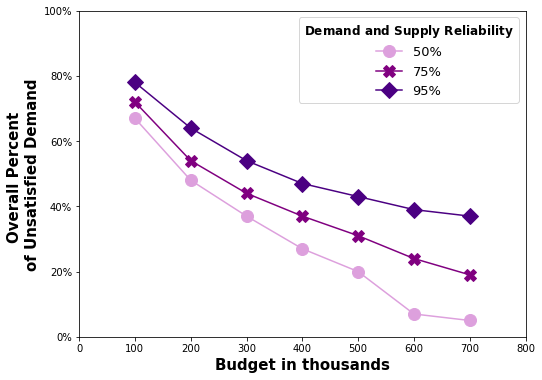

In [24]:
fig, ax = plot.subplots(figsize=(8,6))


ax.plot('budget_thousands', 'percent_unsatisfied', 
          data=reliability_df_grouped[reliability_df_grouped['reliability_level'] == reliability_levels[0]],
         marker='o', color = 'plum', label = '50%', markersize=12)#r'$\theta^D = \theta^{CAP}$ = 0' + ' (Assuming Expected Demand and Supplier Capacity)')
ax.plot('budget_thousands', 'percent_unsatisfied', 
          data=reliability_df_grouped[reliability_df_grouped['reliability_level'] == reliability_levels[1]],
         marker='X', color = 'purple', label = '75%', markersize=12) #r'$\theta^D = \theta^{CAP}$ = 1' + ' (Assuming Some Variability in Demand and Supplier Capacity)')
ax.plot('budget_thousands', 'percent_unsatisfied', 
          data=reliability_df_grouped[reliability_df_grouped['reliability_level'] == reliability_levels[2]],
         marker='D', color = 'indigo', label = '95%', markersize=12)#r'$\theta^D = \theta^{CAP}$ = 2' + ' (high reliability)')

ax.set_xlabel('Budget in thousands', fontweight = 'bold', fontsize = 15)
ax.set_ylabel('Overall Percent \nof Unsatisfied Demand', fontweight='bold', fontsize = 15)

#ax.set(ylim=(0, 1), xlim=(0, max(reliability_df_grouped['budget'])))
ax.set(ylim=(0, 100), xlim=(0, 800))
#ax.set_title(r'$\bf{Overall ~ Expected ~Percent ~of ~Unsatisfied ~Demand}$'+
#             '\n'+ r'$\bf{Under ~Various~ Budgets ~and ~Variability~ in~Demand ~and ~Supplier~Capacity~Assumptions~}$' +
#             '\n \n \n where the expected percent of unsatisfied demand for each item during week'#+ r'$(t)$' + ', represented by: \n'+\
              #r'$\psi_{k,t} = \frac{\alpha_{k,t}}{\alpha_{k,t} + \sum_{i \in I} \beta_{k,i,t}} \forall k \in K, t \in T$' +
#             '\n ...is averaged over all items and time intervals to obtain the '#+  r'$(K)$'+ ' and time intervals '+  r'$(T)$'+ ' to obtain the:'\
#             '\n overall expected percent of unsatisfied demand',# + r'$\frac{\sum_{t \in T} \sum_{k \in K} \psi_{k,t}}{K \times T}$',
#             fontsize = 16)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plot.legend(title = r'$\bf{Demand~and~Supply~Reliability}$', fontsize=13, fancybox=True)

In [25]:
stats_df = fulfilled_df_plan[(fulfilled_df_plan['reliability_level'] == .75)&
                 (fulfilled_df_plan['budget'] >= 300000)&
                 (fulfilled_df_plan['budget'] <= 700000)&
                            ((fulfilled_df_plan['units_fulfilled'] > 0))].reset_index()
stats_df = stats_df[['budget','supplier', 'time_interval', 'time_interval_req', 'units_fulfilled']]
stats_df['quality'] = [int((model.q_k_i[1,x]%1)*10) for x in stats_df['supplier']]
stats_df['delay'] = stats_df['time_interval'] - stats_df['time_interval_req']
stats_df = stats_df[stats_df['delay'] >= 0]
stats_df['health_care_commodity_metric'] = stats_df['quality']*(1/(2**stats_df['delay']))
stats_df['quality_norm'] = stats_df['quality']*stats_df['units_fulfilled']
stats_df['delay_norm'] = stats_df['delay']*stats_df['units_fulfilled']
stats_df['health_care_commodity_metric_norm']=stats_df['health_care_commodity_metric']*stats_df['units_fulfilled']

In [26]:
stats_df_grouped = stats_df.groupby(['budget'])\
.agg({'quality_norm':'sum', 'delay_norm':'sum','health_care_commodity_metric_norm':'sum',
     'units_fulfilled':'sum'}).reset_index()
hcc_pct_change_temp = stats_df_grouped['health_care_commodity_metric_norm'].pct_change()
hcc_pct_change = []

In [27]:
for i in hcc_pct_change_temp:
    if np.isnan(i):
        hcc_pct_change.append(' ')
    else:
        hcc_pct_change.append("{:.2%}".format(i))

In [28]:
stats_df_grouped['quality_norm'] = stats_df_grouped['quality_norm']/stats_df_grouped['units_fulfilled']
stats_df_grouped['delay_norm'] = stats_df_grouped['delay_norm']/stats_df_grouped['units_fulfilled']
stats_df_grouped['hcc_pct_change'] = hcc_pct_change

In [29]:
stats_df_grouped = stats_df_grouped[stats_df_grouped['budget'] > 300000]

In [30]:
temp = reliability_df_grouped[(reliability_df_grouped['reliability_level'] == .75)&
                      (reliability_df_grouped['budget_thousands'] <= 700)&
                      (reliability_df_grouped['budget_thousands'] >= 400)]

temp = ["{:.2%}".format(x) for x in temp['risk_of_understock']]

In [31]:
stats_df_grouped['unsatisfied_demand'] = temp

In [32]:
stats_df_grouped

,budget,quality_norm,delay_norm,health_care_commodity_metric_norm,units_fulfilled,hcc_pct_change,unsatisfied_demand
1,400000,1.078867,0.271494,463851.367899,507184.341570,19.14%,37.54%
2,500000,1.176505,0.245964,585058.795442,567467.807745,26.13%,31.87%
3,600000,1.224747,0.221461,685244.687446,640124.953702,17.12%,24.58%
4,700000,1.234688,0.304062,715134.984266,688226.137631,4.36%,19.28%
